
# Demonstration of Uplift Modeling using pylift
***
Pylift is a python library that provides fast uplift modeling implementations and evaluation tools. It is designed to be quick, flexible, and effective. 

Documentation for Pylift can be found <a href="https://pylift.readthedocs.io/en/latest/" target="_blank">here</a>. 


In [1]:
import pandas as pd
import numpy as np
import pylift
import matplotlib.pyplot as plt

## Dataset
***

For our demonstration, we are using data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

* The **treatment** variable in the case was whether or not the customer was contacted, with no contact('unknown') signifying control group   
* The **outcome** variable was whether the customer subscribed to the bank's term deposit product

For each customer, demographic information such as age, job, marital status, etc., is available as predictors. For more details, refer to the <a href="https://archive.ics.uci.edu/ml/datasets/bank+marketing" target="_blank">source</a>. 

In [2]:
Telemarketing_data = pd.read_csv("bank-full.csv",sep=';',usecols=[0,1,2,3,4,5,6,7,8,11,12,13,16])
Telemarketing_data.columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing_loan'
                              ,'personal_loan', 'treatment', 'duration', 'campaign_connects', 'pdays', 'outcome']
Telemarketing_data.head()

,age,job,marital,education,default,balance,housing_loan,personal_loan,treatment,duration,campaign_connects,pdays,outcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,no


***
# Data pre-processing

Converting categorical variables to numerical using one-hot encoding 

In [3]:
Telemarketing_data['outcome'] = Telemarketing_data['outcome'].apply(lambda x: 1 if x=="yes" else 0)
Telemarketing_data['treatment'] = Telemarketing_data['treatment'].apply(lambda x: 0 if x=='unknown' else 1)

In [4]:
Telemarketing_data['default'] = Telemarketing_data['default'].apply(lambda x: 1 if x =='yes' else 0)
Telemarketing_data['housing_loan'] = Telemarketing_data['housing_loan'].apply(lambda x: 1 if x =='yes' else 0)
Telemarketing_data['housing_loan'] = Telemarketing_data['housing_loan'].apply(lambda x: 1 if x =='yes' else 0)

In [5]:
Telemarketing_data2  = pd.get_dummies(Telemarketing_data)

***
## Creating a transformed outcome class

pylift uses a transfomed outcome class methodology for implementing uplift modeling. There is an in-built function for data preparation *TransformedOutcome* that takes the **treatment** and the **outcome** column names as inputs separately to create a transformed class.

In [6]:
uplift_model = pylift.TransformedOutcome(Telemarketing_data2, col_treatment='treatment', col_outcome='outcome')

***
### Exploring the TransformedOutcome class

We can see from the below snapshot that for cases where we don't have a desired outcome value, the value for the TransformedOutcome column is 0. For the case when we get desired outcome without treatment, the value is a negative number. However, the case when we have the desired outcome when treatment is applied, the value of the TransformedOutcome is positive.

In [7]:
uplift_model.df[['treatment','outcome','TransformedOutcome']].drop_duplicates().reset_index(drop=True)

,treatment,outcome,TransformedOutcome
0,0,0,-0.0
1,0,1,-3.472427
2,1,0,0.0
3,1,1,1.404461


***
# Model Building & Parameter Tuning

pylift dervies the functionalities from sklearn to build XGBoost Regressor. It also has the functionalities of model tuning using GridSearchCV and RandomizedSearch to facilitate hyperparamtertuning derived from the sklearn module

* **pylift.fit()** - Used to fit a sklearn Regressor with any arguments relevant to the model type. Paramters for the XGBoost Regressor can be found in this <a href="https://xgboost.readthedocs.io/en/latest/parameter.html" target="_blank">link</a>
* **pylift.randomized_search()** - Used for hyperparamter tuning to test various model parameters for a given Regressor.Further documentation on the same can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html" target="_blank">here</a>

***
#### Using paramter tuning to find the best paramters

In [8]:
uplift_model.randomized_search(n_iter = 10,n_jobs = 5,cv = 3, random_state = 0, verbose = 2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                   

#### Building a XGBoost model using the best parameters

In [10]:
uplift_model.fit(**uplift_model.rand_search_.best_params_)

***
# Model Evaluation

A model's performance can be evaluated using a Qini Curve and Gains Chart. It is a way of measuring how good a model is at separating positive and negative uplift values.

* *A typical “gains chart” plots the cumulative outcome rate as a function of the fraction of population. A random model produces no gain over the diagonal, while a good model tends to produce the bow-shaped curve sketched here because the model ranks higher outcomes to the left*
* *Qini curve plots the cumulative uplift across the population. Here, we rank the customers by their predicted uplift on the horizontal axis, and the vertical axis plots the cumulative number of positive outcomes in the treatment group (scaled by the total treatment size) minus the cumulative number of postive outcomes in control (scaled by the total control size)*

In each of these plots we have also have -

1) **Practical Max** curve, for which we also assume that all individuals that have a positive outcome in the treatment group must also have a counterpart in the control group that did not respond

2) **No sleeping dog** curve, which simply precludes the possibility of negative effects

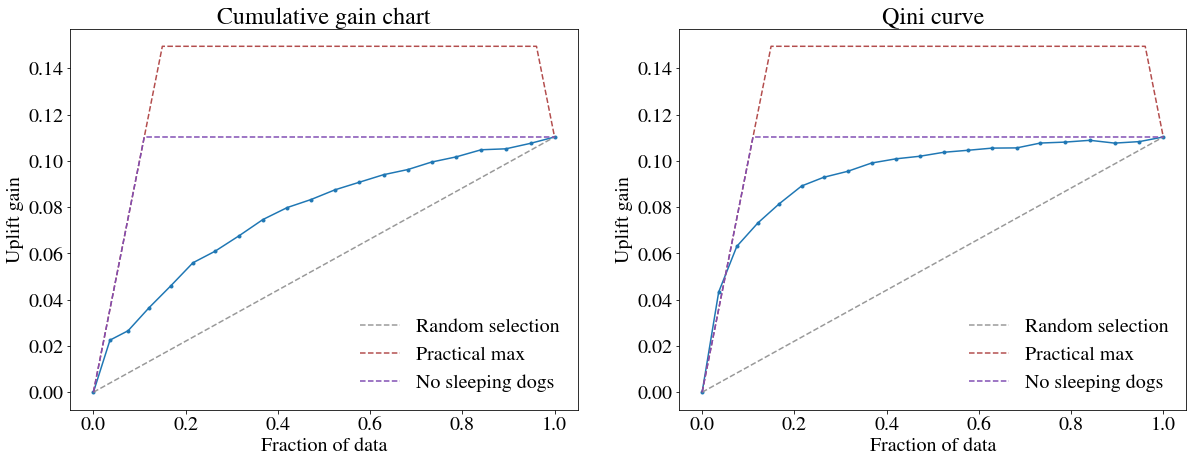

In [58]:
f = plt.figure(figsize=(20,7))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
uplift_model.plot(plot_type='cgains', show_practical_max=True, show_no_dogs=True,ax=plt.subplot(1,2,1)) 
uplift_model.plot(plot_type='qini', show_practical_max=True, show_no_dogs=True,ax=plt.subplot(1,2,2))
plt.show()

## Feature Importance

We can also plot the feature importance of various predictors in the model based on their information value.

<AxesSubplot:xlabel='NIV', ylabel='Features'>

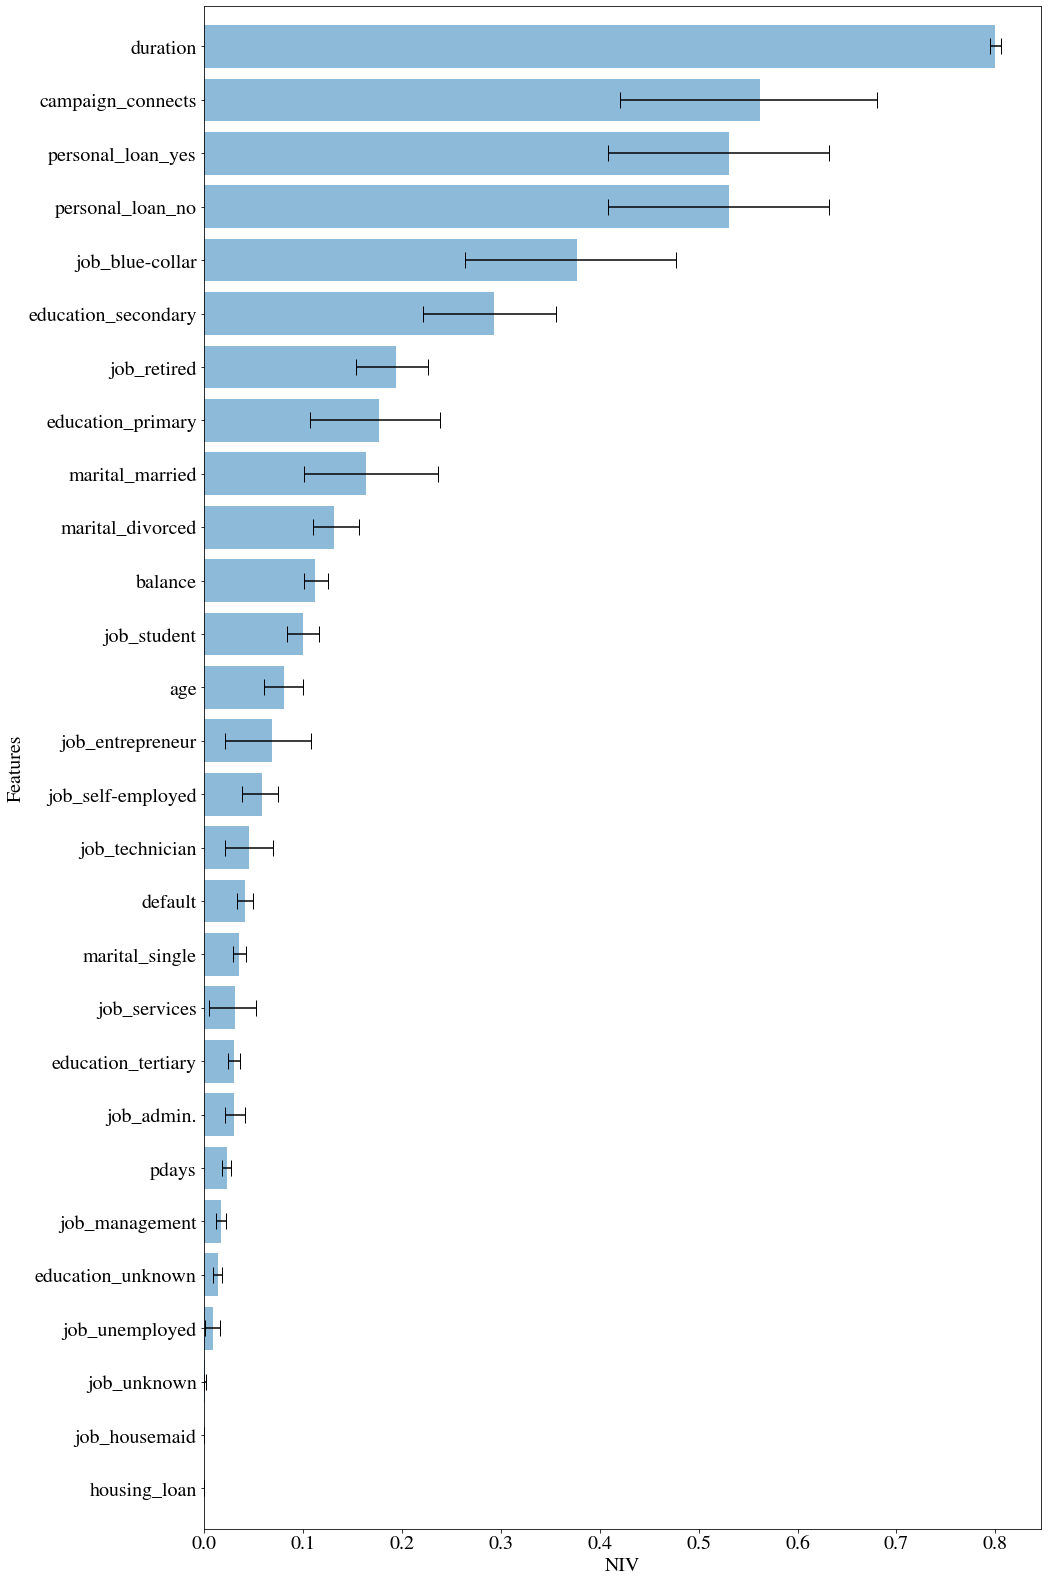

In [68]:
uplift_model.NIV()

**The above demo can be replicated to fit any business case trying to apply uplift modeling. Please reach out to us for a detailed walkthrough of the same or in case of clarifications on the theoretical working of the above procedures.**

Contact our team using the below details -
* Lydia Savatsky - savat010@umn.edu
* Aleksandra Singer - singe240@umn.edu
* Venkata Yashish Reddy Sajjala - sajja032@umn.edu
* Sourabh Koul - koul0009@umn.edu
* Manish Jain - jain0247@umn.edu